In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
from surrogate import rules

from utils.df_loader import load_adult_df, load_compas_df, load_german_df, load_diabetes_df, load_breast_cancer_df
from utils.preprocessing import preprocess_df
from sklearn.model_selection import train_test_split
from utils.dice import generate_dice_result, process_results
from utils.models import train_three_models, evaluation_test, save_three_models, load_three_models
from utils.save import save_result_as_csv
from IPython.display import Image
import PIL
import pydotplus
from six import StringIO
from sklearn.tree import export_graphviz
from pydotplus import *


pd.options.mode.chained_assignment = None 

print('TF version: ', tf.__version__)
print('Eager execution enabled: ', tf.executing_eagerly()) # False

seed = 123
tf.random.set_seed(seed)
np.random.seed(seed)


TF version:  2.0.0
Eager execution enabled:  True


In [2]:
def get_location(scaler, col):
    if col in scaler.feature_names_in_:
        return np.where(scaler.feature_names_in_ == col)[0]
    
    else:
        raise Exception(f"Column [{col}] not a feature in this scaler, scaler features: {scaler.feature_names_in_}")


def get_scaled_value(scaler, col, X):
    loc=get_location(scaler, col)

    X *= scaler.scale_[loc]
    X += scaler.min_[loc]

    if scaler.clip:
        np.clip(X, scaler.feature_range[0][loc], scaler.feature_range[1][loc], out=X)
    
    return X[0]


def get_original_value(scaler, col, X):
    loc = get_location(scaler, col)

    X -= scaler.min_[loc]
    X /= scaler.scale_[loc]

    return X[0]

In [3]:

# VISUALISE_DECISION_TREE_PATH
# 
def visualize_decision_tree_path( clf, graph, instance, indx, exp_type, path ):  

  for i, node in enumerate(graph.get_node_list()):
    if node.get_attributes().get('label') is None:
        continue

    if 'samples = ' in node.get_attributes()['label']:
        labels = node.get_attributes()['label'].split('<br/>')
        for i, label in enumerate(labels):
            if label.startswith('samples = '):
                labels[i] = 'samples = 0'
        node.set('label', '<br/>'.join(labels))
        node.set_fillcolor('white')
    
    lable_str = node.get_attributes()['label']  
    feature_value_str = (lable_str.split("<br/>")[0]).replace('<','')
    feature_name = feature_value_str.split(" ")[0]
    if feature_name in df_info.scaler.feature_names_in_:
      feature_value = float(feature_value_str.split(" ")[-1])
      original_value = get_original_value(df_info.scaler, feature_name , feature_value)
      #print(f"name: {feature_name}. value: {feature_value}, original_value: {original_value}")
      original_lable_str = lable_str.replace(feature_value_str, ' '.join([*(feature_value_str.split(' '))[:-1],f'{original_value:.2f}']))
      node.set('label', original_lable_str)
    #raise StopIteration()

  samples = instance
  
  decision_paths = clf.decision_path( [samples] )

  for decision_path in decision_paths:
    for n, node_value in enumerate(decision_path.toarray()[0]):
      if node_value == 0:
        continue
      node = graph.get_node(str(n))[0]            
      node.set_fillcolor('green')
      labels = node.get_attributes()['label'].split('<br/>')
      for i, label in enumerate(labels):
        if label.startswith('samples = '):
          labels[i] = 'samples = {}'.format(int(label.split('=')[1]) + 1)
      
      node.set('label', '<br/>'.join(labels))

  filename = path
  graph.write_png(filename)

  im = PIL.Image.open(filename)
  return im


# EXTRACT_DECISION_PATH
# 
def extract_decision_path(clf, graph, instance ):

  #samples = instance['scaled_vector']
  #decision_paths = clf.decision_path( [samples] )
  samples = instance
  decision_paths = clf.decision_path( [samples] )

  for decision_path in decision_paths:
    path = []
    for n, node_value in enumerate(decision_path.toarray()[0]):
      if node_value == 0:
        continue

      node = graph.get_node(str(n))[0]
      labels = node.get_attributes()['label'].split('<br/>')
      labels.pop(1)
      try:
        labels.remove("samples = 1")
        labels.remove("samples = 0")
        labels.remove("gini = 0.0")
      except ValueError:
        labels
      path.append(labels)
  return path

def export_decision_tree(clf, class_names, DATASET_NAME, path):
  dot_data = StringIO()
  export_graphviz(clf, out_file=dot_data,  
                  filled=True, rounded=True,
                  special_characters=True, feature_names = feature_names,
                  class_names=class_names)

  # convert to png format
  graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
  graph.write_png(path)
  return graph


In [4]:
#### Select dataset ####'

dataset_name = 'breast_cancer' # [adult, german, compas]

if dataset_name == 'adult':
    dataset_loading_fn = load_adult_df
elif dataset_name == 'german':
    dataset_loading_fn = load_german_df
elif dataset_name == 'compas':
    dataset_loading_fn = load_compas_df
elif dataset_name == 'diabetes':
    dataset_loading_fn = load_diabetes_df
elif dataset_name == 'breast_cancer':
    dataset_loading_fn = load_breast_cancer_df
else:
    raise Exception("Unsupported dataset")

In [5]:
#pip install pillow
#pip install dtreeviz
#pip install Graphviz
from dtreeviz.trees import *
from sklearn.tree import DecisionTreeClassifier
dice_dt = pd.read_csv(r'./datasets/eval_dice_breast_cancer_dt_result.csv')


In [6]:
dice_dt

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,scaled_input_diagnosis,scaled_input_radius_mean,scaled_input_texture_mean,scaled_input_perimeter_mean,scaled_input_area_mean,scaled_input_smoothness_mean,scaled_input_compactness_mean,...,running_time,Found,ground_truth,prediction,L1,L2,Sparsity,Realistic,MAD,Mahalanobis
0,0.0,0.0,0.0,N,0.202045,0.171458,0.190657,0.104560,0.274713,0.077296,...,0.049867,Y,N,N,1.143370,0.850880,2.00,True,0.498983,0.106243
1,1.0,0.0,0.0,N,0.202045,0.171458,0.190657,0.104560,0.274713,0.077296,...,0.052858,Y,N,N,0.688278,0.605258,2.00,True,0.313775,0.071675
2,2.0,0.0,0.0,N,0.202045,0.171458,0.190657,0.104560,0.274713,0.077296,...,0.046879,Y,N,N,0.836662,0.643709,2.00,True,0.195011,0.143060
3,3.0,0.0,0.0,N,0.202045,0.171458,0.190657,0.104560,0.274713,0.077296,...,0.049831,Y,N,N,1.163413,0.835901,2.00,True,0.459935,0.126571
4,4.0,0.0,0.0,N,0.202045,0.171458,0.190657,0.104560,0.274713,0.077296,...,0.046872,Y,N,N,1.463617,1.039123,2.00,True,0.505250,0.198156
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,96.0,19.0,0.0,N,0.239907,0.166385,0.236680,0.129714,0.455629,0.219434,...,0.049870,Y,N,N,0.532230,0.532230,1.00,True,0.258826,0.053447
97,97.0,19.0,0.0,N,0.239907,0.166385,0.236680,0.129714,0.455629,0.219434,...,0.049898,Y,N,N,1.043271,0.864296,2.00,True,0.459919,0.111366
98,98.0,19.0,0.0,N,0.239907,0.166385,0.236680,0.129714,0.455629,0.219434,...,0.047873,Y,N,N,2.179110,1.268831,3.00,True,0.800653,0.254226
99,99.0,19.0,0.0,N,0.239907,0.166385,0.236680,0.129714,0.455629,0.219434,...,0.049867,Y,N,N,1.456803,1.031169,2.00,True,0.577672,0.128614


In [7]:
dice_dt

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,scaled_input_diagnosis,scaled_input_radius_mean,scaled_input_texture_mean,scaled_input_perimeter_mean,scaled_input_area_mean,scaled_input_smoothness_mean,scaled_input_compactness_mean,...,running_time,Found,ground_truth,prediction,L1,L2,Sparsity,Realistic,MAD,Mahalanobis
0,0.0,0.0,0.0,N,0.202045,0.171458,0.190657,0.104560,0.274713,0.077296,...,0.049867,Y,N,N,1.143370,0.850880,2.00,True,0.498983,0.106243
1,1.0,0.0,0.0,N,0.202045,0.171458,0.190657,0.104560,0.274713,0.077296,...,0.052858,Y,N,N,0.688278,0.605258,2.00,True,0.313775,0.071675
2,2.0,0.0,0.0,N,0.202045,0.171458,0.190657,0.104560,0.274713,0.077296,...,0.046879,Y,N,N,0.836662,0.643709,2.00,True,0.195011,0.143060
3,3.0,0.0,0.0,N,0.202045,0.171458,0.190657,0.104560,0.274713,0.077296,...,0.049831,Y,N,N,1.163413,0.835901,2.00,True,0.459935,0.126571
4,4.0,0.0,0.0,N,0.202045,0.171458,0.190657,0.104560,0.274713,0.077296,...,0.046872,Y,N,N,1.463617,1.039123,2.00,True,0.505250,0.198156
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,96.0,19.0,0.0,N,0.239907,0.166385,0.236680,0.129714,0.455629,0.219434,...,0.049870,Y,N,N,0.532230,0.532230,1.00,True,0.258826,0.053447
97,97.0,19.0,0.0,N,0.239907,0.166385,0.236680,0.129714,0.455629,0.219434,...,0.049898,Y,N,N,1.043271,0.864296,2.00,True,0.459919,0.111366
98,98.0,19.0,0.0,N,0.239907,0.166385,0.236680,0.129714,0.455629,0.219434,...,0.047873,Y,N,N,2.179110,1.268831,3.00,True,0.800653,0.254226
99,99.0,19.0,0.0,N,0.239907,0.166385,0.236680,0.129714,0.455629,0.219434,...,0.049867,Y,N,N,1.456803,1.031169,2.00,True,0.577672,0.128614


In [8]:
test1 = dice_dt.nsmallest(1,['L2'])
test1

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,scaled_input_diagnosis,scaled_input_radius_mean,scaled_input_texture_mean,scaled_input_perimeter_mean,scaled_input_area_mean,scaled_input_smoothness_mean,scaled_input_compactness_mean,...,running_time,Found,ground_truth,prediction,L1,L2,Sparsity,Realistic,MAD,Mahalanobis
16,16.0,3.0,0.0,N,0.285342,0.423064,0.264114,0.162418,0.089194,0.0,...,0.047915,Y,N,N,0.123981,0.123981,1.0,True,0.031568,0.02031


### Get the index for ground truth and prediction

In [9]:
test = dice_dt.nlargest(1,['L2'])
test

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,scaled_input_diagnosis,scaled_input_radius_mean,scaled_input_texture_mean,scaled_input_perimeter_mean,scaled_input_area_mean,scaled_input_smoothness_mean,scaled_input_compactness_mean,...,running_time,Found,ground_truth,prediction,L1,L2,Sparsity,Realistic,MAD,Mahalanobis
23,23.0,4.0,0.0,Y,0.543282,0.297937,0.534241,0.395122,0.416268,0.263542,...,0.051857,Y,Y,Y,2.554837,1.372948,4.0,True,1.039974,0.259486


In [10]:
test = dice_dt.nlargest(3,['L2'])
test

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,scaled_input_diagnosis,scaled_input_radius_mean,scaled_input_texture_mean,scaled_input_perimeter_mean,scaled_input_area_mean,scaled_input_smoothness_mean,scaled_input_compactness_mean,...,running_time,Found,ground_truth,prediction,L1,L2,Sparsity,Realistic,MAD,Mahalanobis
23,23.0,4.0,0.0,Y,0.543282,0.297937,0.534241,0.395122,0.416268,0.263542,...,0.051857,Y,Y,Y,2.554837,1.372948,4.0,True,1.039974,0.259486
54,54.0,10.0,0.0,N,0.345923,0.240446,0.321401,0.207466,0.105263,0.022606,...,0.051993,Y,N,N,2.408113,1.344254,5.0,True,0.923395,0.242434
98,98.0,19.0,0.0,N,0.239907,0.166385,0.236680,0.129714,0.455629,0.219434,...,0.047873,Y,N,N,2.179110,1.268831,3.0,True,0.800653,0.254226


In [11]:
dice_dt.nlargest(3,['L2'])

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,scaled_input_diagnosis,scaled_input_radius_mean,scaled_input_texture_mean,scaled_input_perimeter_mean,scaled_input_area_mean,scaled_input_smoothness_mean,scaled_input_compactness_mean,...,running_time,Found,ground_truth,prediction,L1,L2,Sparsity,Realistic,MAD,Mahalanobis
23,23.0,4.0,0.0,Y,0.543282,0.297937,0.534241,0.395122,0.416268,0.263542,...,0.051857,Y,Y,Y,2.554837,1.372948,4.0,True,1.039974,0.259486
54,54.0,10.0,0.0,N,0.345923,0.240446,0.321401,0.207466,0.105263,0.022606,...,0.051993,Y,N,N,2.408113,1.344254,5.0,True,0.923395,0.242434
98,98.0,19.0,0.0,N,0.239907,0.166385,0.236680,0.129714,0.455629,0.219434,...,0.047873,Y,N,N,2.179110,1.268831,3.0,True,0.800653,0.254226


### <font color='yellow'>Task: True positive select 3 CF have the best l2 and select the 3 CF have the worst L2 </font>


##### (1.) Get the true positive rows and (2.) select the top and worst L2

In [12]:
# top n rows ordered by multiple columns
dice_dt_lg3 = dice_dt.nlargest(3,['L2'])
dice_dt_sm3 = dice_dt.nsmallest(3,['L2'])

In [13]:
#### Load datafram info.
df_info = preprocess_df(dataset_loading_fn)
### Seperate to train and test set.
train_df, test_df = train_test_split(df_info.dummy_df, train_size=.8, random_state=seed, shuffle=True)
### Get training and testing array.
X_train = np.array(train_df[df_info.ohe_feature_names])
y_train = np.array(train_df[df_info.target_name])
X_test = np.array(test_df[df_info.ohe_feature_names])
y_test = np.array(test_df[df_info.target_name])
### Load models.
models = load_three_models(X_train.shape[-1], dataset_name)

/Users/yu-liangchou/opt/anaconda3/envs/cf_2022_final/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/Users/yu-liangchou/opt/anaconda3/envs/cf_2022_final/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
2022-04-26 22:06:56.292799: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) M

In [14]:
#### import evaluation function.
from utils.evaluation import prepare_evaluation_dict
input_and_cf = prepare_evaluation_dict(dice_dt, df_info)


clf=models['dt']
#clf = DecisionTreeClassifier()
class_names = ["No Breast cancer", "Yes Breast Cancer"]



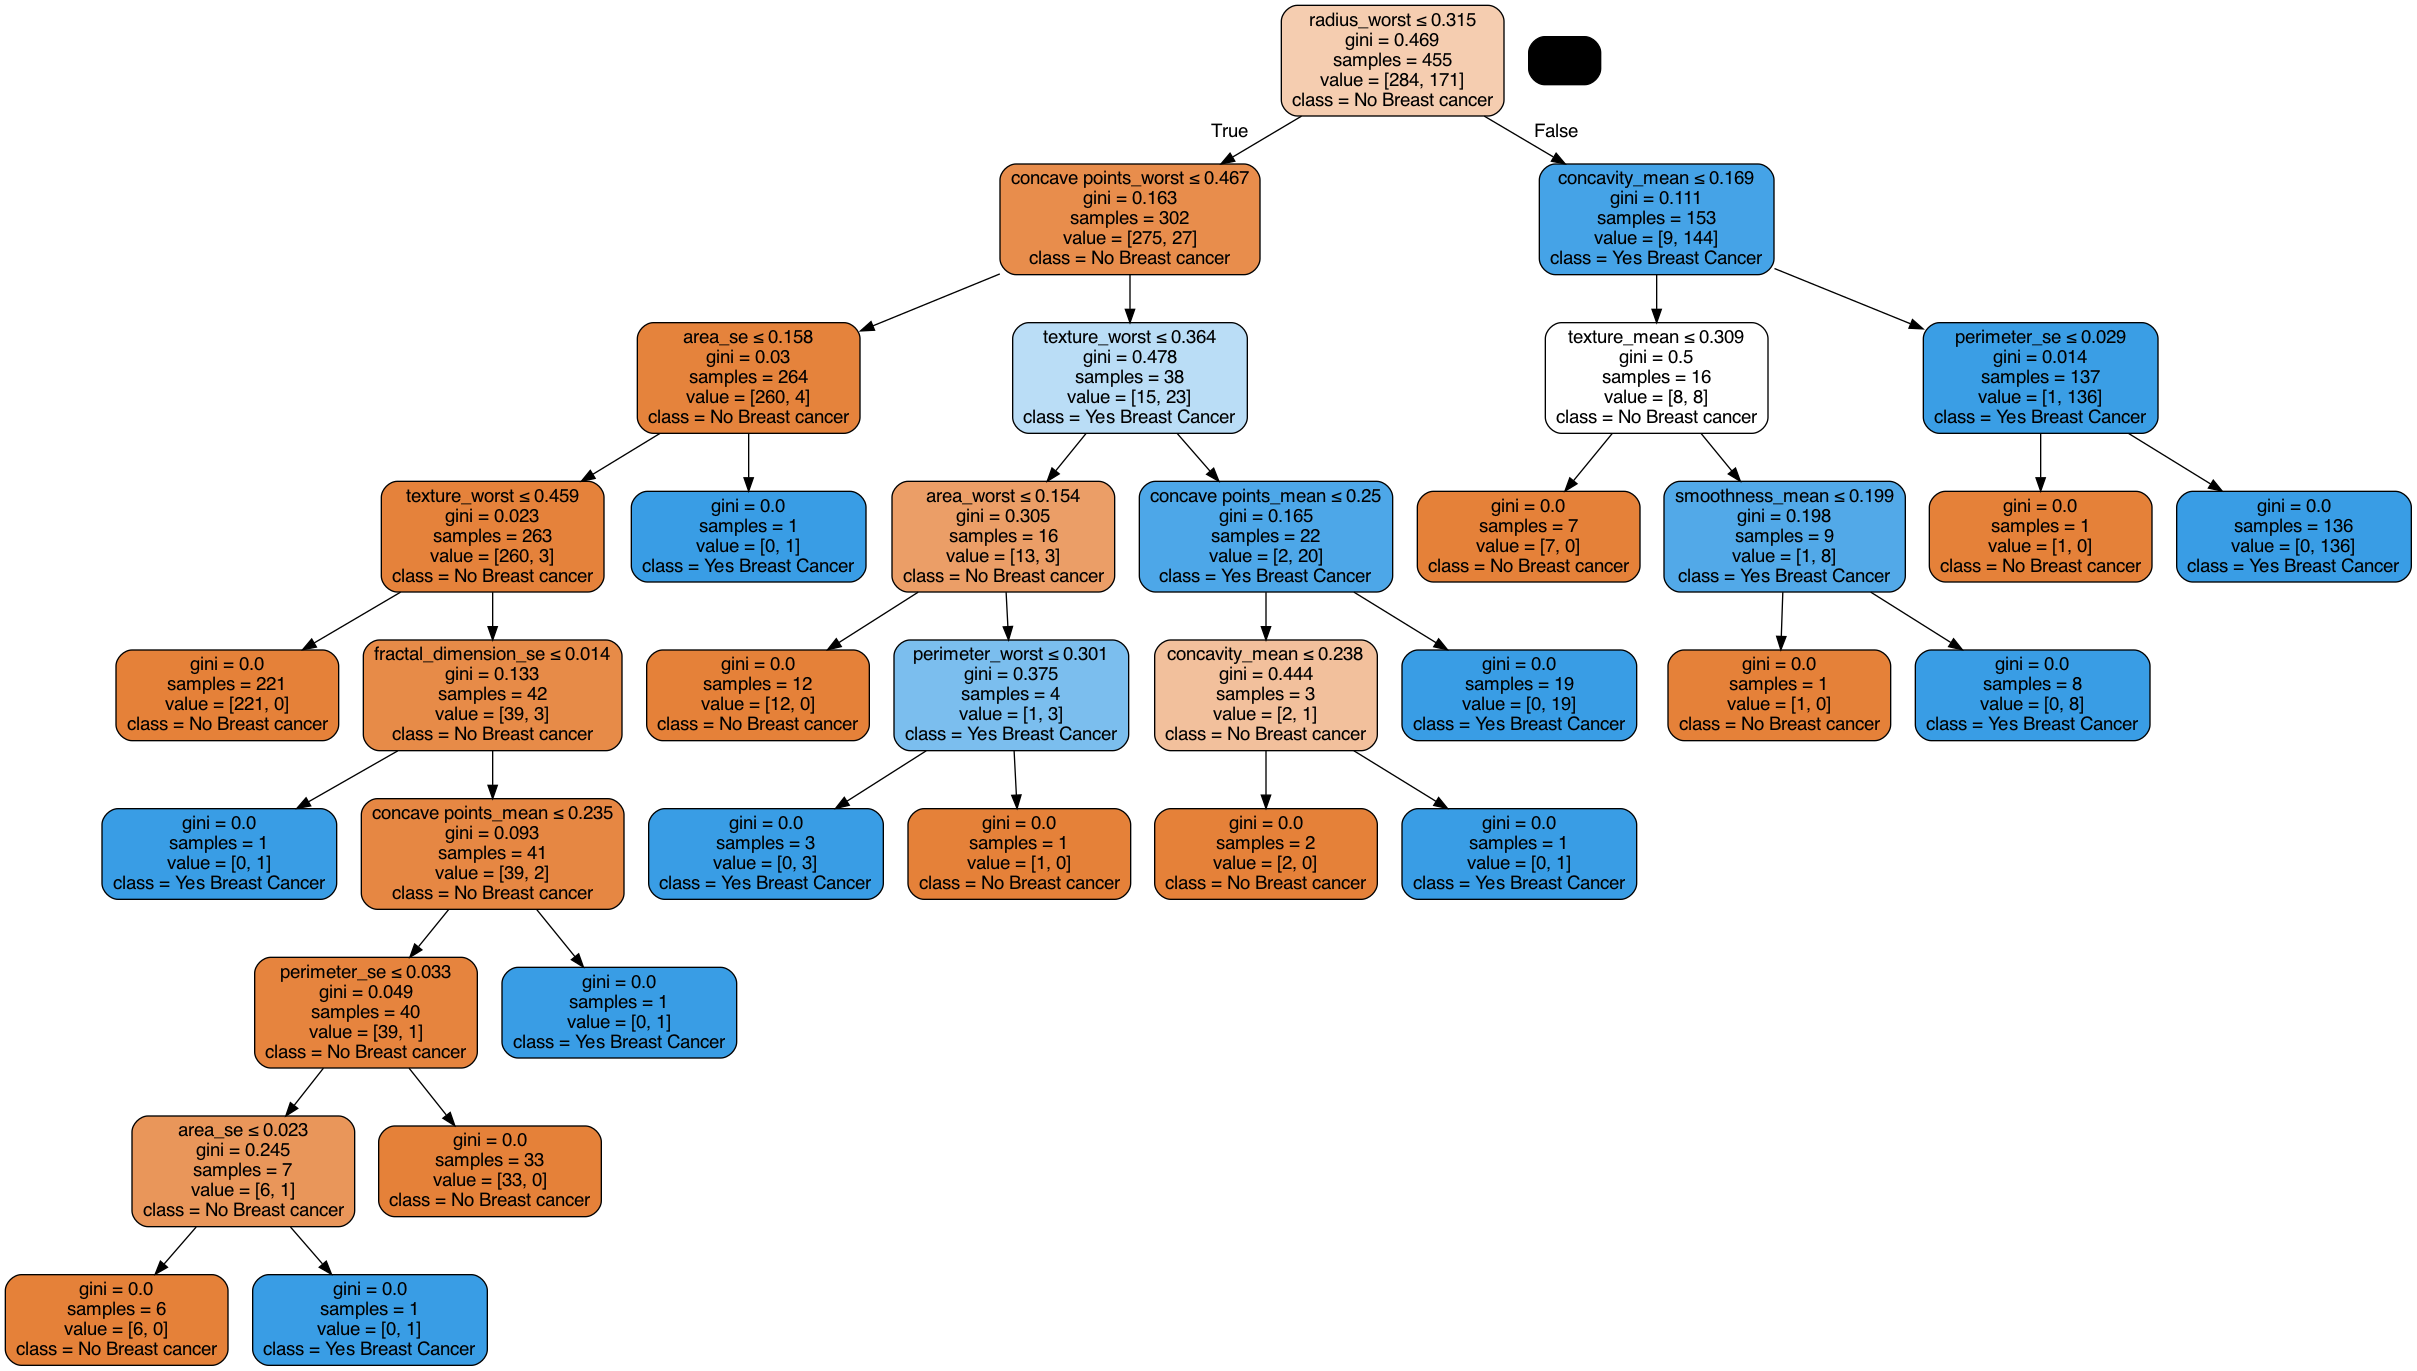

In [15]:
#filepath = PATH + 'Whitebox_Model/explanations/' + DATASET_NAME.replace(".csv", "")+ '/Decision_Tree/' + exp_type + '/decision_tree_general_' + str(INDX) + '.png'
PATH = "GitHub/Counterfactual-benchmark/"
dataset_name = 'breast_cancer' # [adult, german, compas]
filepath = "/Users/yu-liangchou/Desktop/cf_experiment/tree.png"
feature_names=df_info.feature_names
graph = export_decision_tree(clf, class_names, dataset_name, filepath) 


Image(graph.create_png())

[Text(0.5476190476190477, 0.9444444444444444, 'node #0\nradius_worst <= 0.315\ngini = 0.469\nsamples = 455\nvalue = [284, 171]'),
 Text(0.2857142857142857, 0.8333333333333334, 'node #1\nconcave points_worst <= 0.467\ngini = 0.163\nsamples = 302\nvalue = [275, 27]'),
 Text(0.14285714285714285, 0.7222222222222222, 'node #2\narea_se <= 0.158\ngini = 0.03\nsamples = 264\nvalue = [260, 4]'),
 Text(0.09523809523809523, 0.6111111111111112, 'node #3\ntexture_worst <= 0.459\ngini = 0.023\nsamples = 263\nvalue = [260, 3]'),
 Text(0.047619047619047616, 0.5, 'node #4\ngini = 0.0\nsamples = 221\nvalue = [221, 0]'),
 Text(0.14285714285714285, 0.5, 'node #5\nfractal_dimension_se <= 0.014\ngini = 0.133\nsamples = 42\nvalue = [39, 3]'),
 Text(0.09523809523809523, 0.3888888888888889, 'node #6\ngini = 0.0\nsamples = 1\nvalue = [0, 1]'),
 Text(0.19047619047619047, 0.3888888888888889, 'node #7\nconcave points_mean <= 0.235\ngini = 0.093\nsamples = 41\nvalue = [39, 2]'),
 Text(0.14285714285714285, 0.2777777

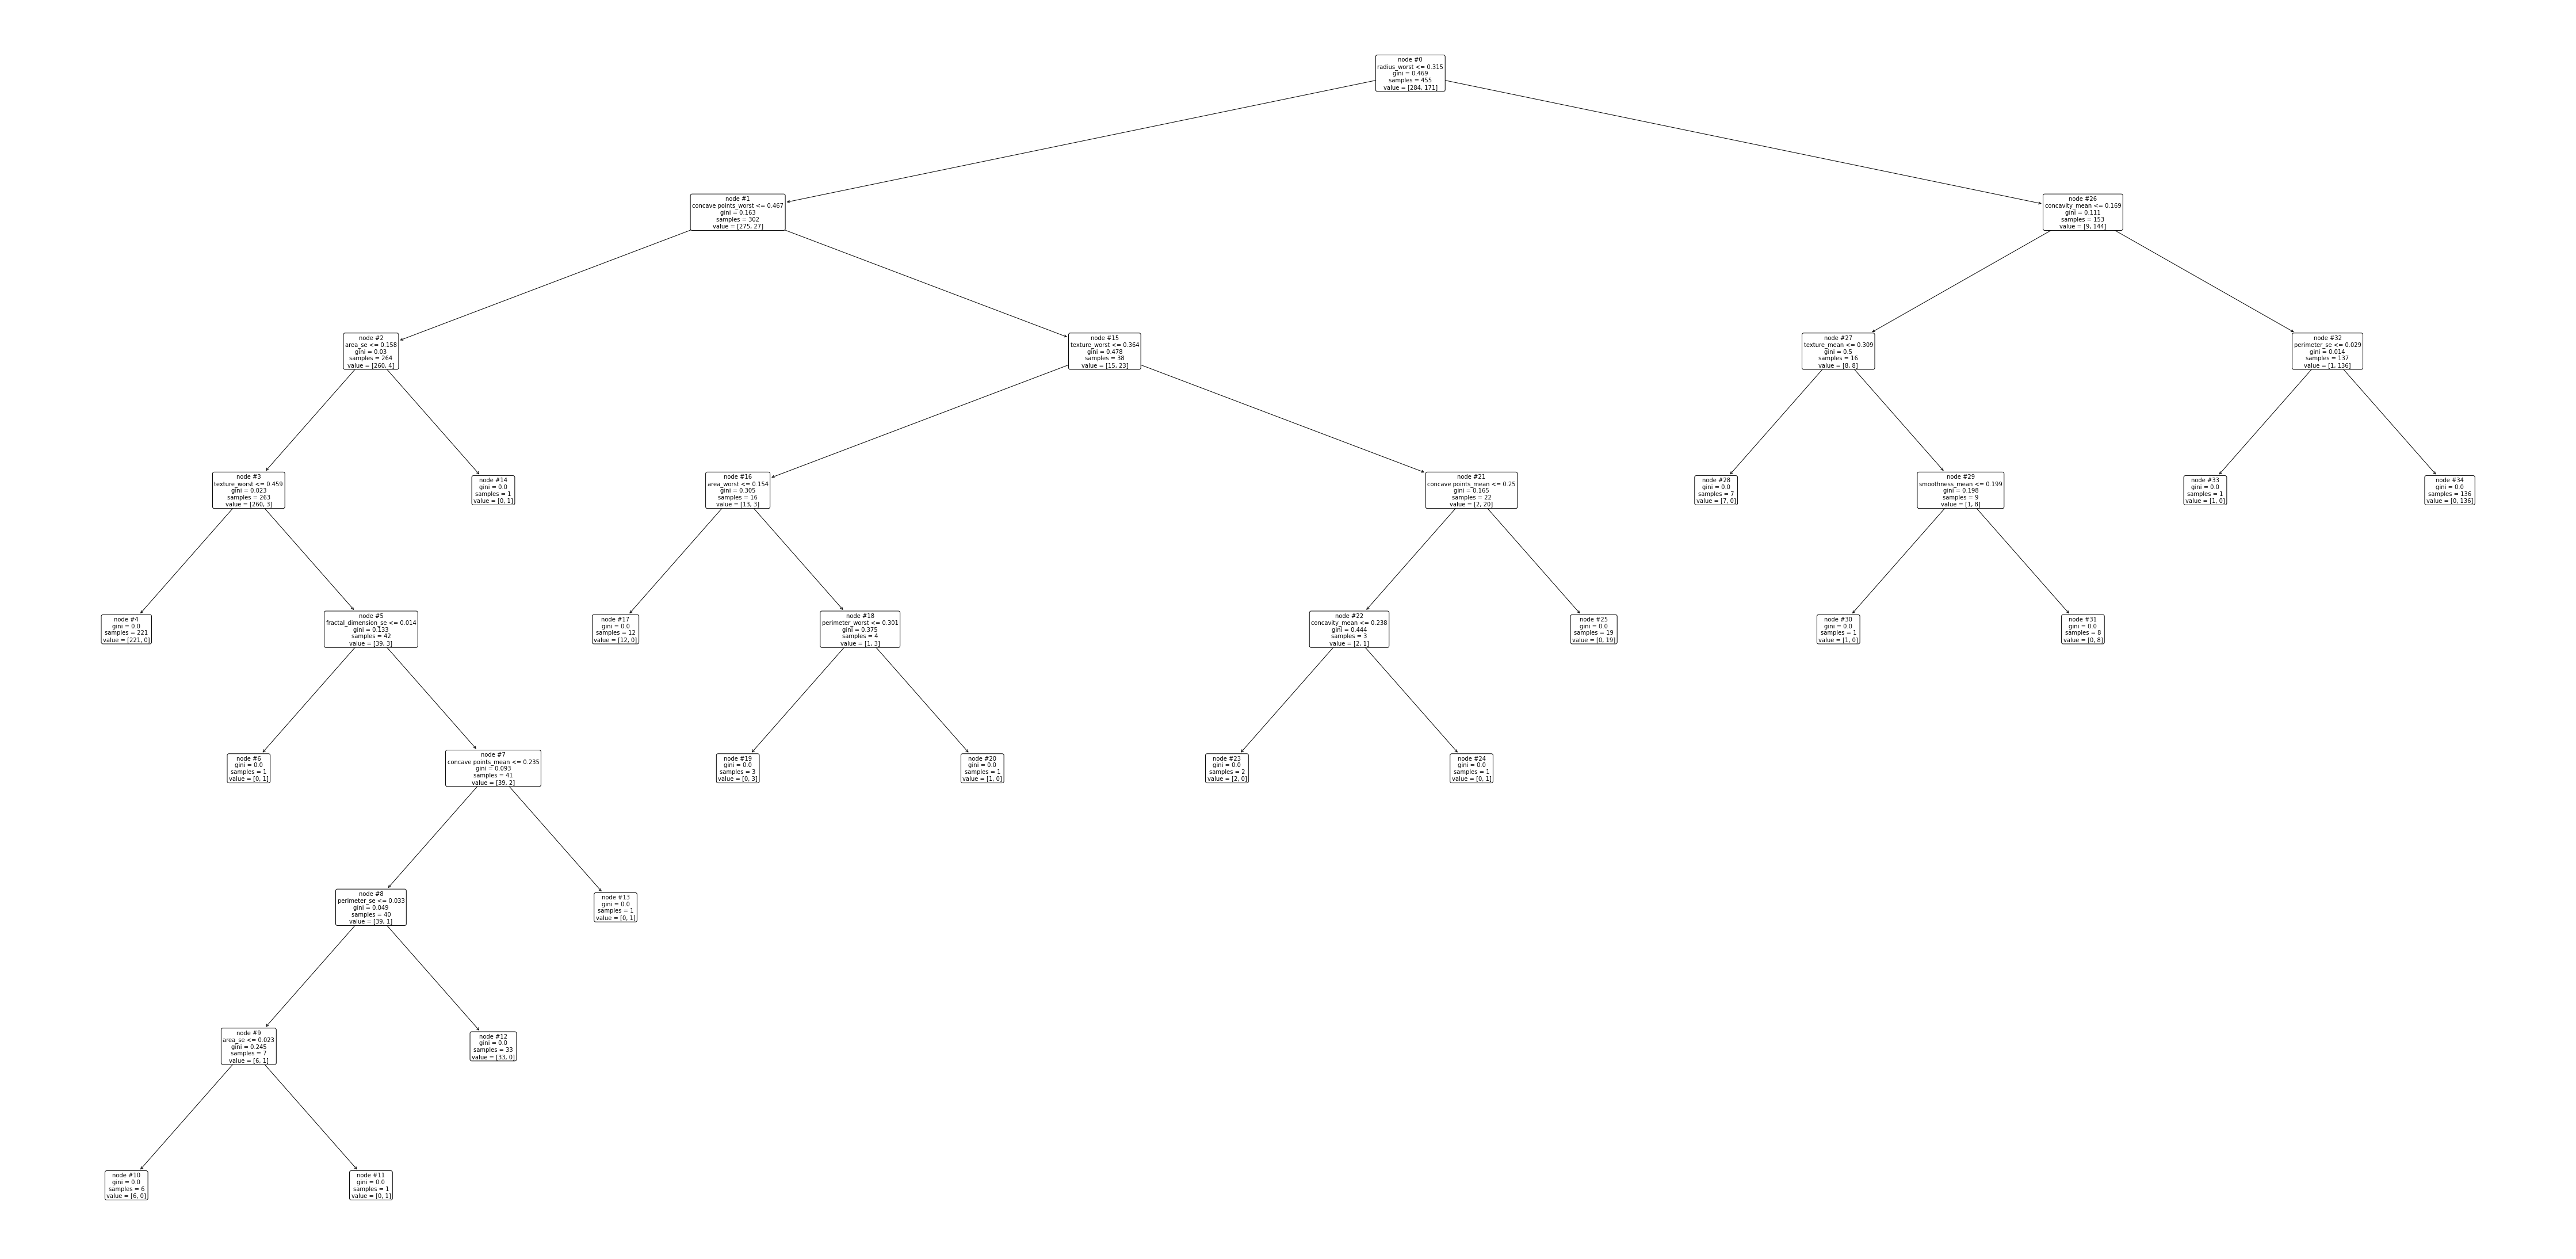

In [16]:
#### Plot the dt tree.
from sklearn import tree
import matplotlib.pyplot as plt
plt.figure(figsize=(80,40))
tree.plot_tree(models['dt'], fontsize=10, feature_names=df_info.feature_names, node_ids=True,rounded=True )
#If you need to colored the class >> filled=True

In [41]:
#### retrieve the input and cf vectors.
dice_input = input_and_cf['input'].loc[71]
dice_cf = input_and_cf['cf'].loc[71]





In [86]:
#Check the key in the list
#print(dice_cf.keys())

In [87]:
#### Present the decision path
tree_path = extract_decision_path(clf, graph, dice_input)
tree_path

[['<radius_worst &le; 0.315',
  'samples = 455',
  'value = [284, 171]',
  'class = No Breast cancer>'],
 ['<concavity_mean &le; 0.169',
  'samples = 153',
  'value = [9, 144]',
  'class = Yes Breast Cancer>'],
 ['<perimeter_se &le; 0.029',
  'samples = 137',
  'value = [1, 136]',
  'class = Yes Breast Cancer>'],
 ['<gini = 0.0', 'value = [0, 136]', 'class = Yes Breast Cancer>']]

In [88]:
decisions, pred, leaf_id = rules.get_decision_process(np.array(dice_input).reshape(1, -1), models['dt'], df_info.feature_names)
print(leaf_id)


decision node 0 : (x [radius_worst] = 0.533617914) > 0.3153682053089142)
decision node 26 : (x [concavity_mean] = 0.312792867) > 0.16902530938386917)
decision node 32 : (x [perimeter_se] = 0.189652741) > 0.029001555405557156)
34


In [89]:
decisions, pred, leaf_id = rules.get_decision_process(np.array(dice_cf).reshape(1, -1), models['dt'], df_info.feature_names)
print(leaf_id)

decision node 0 : (x [radius_worst] = 0.533617914) > 0.3153682053089142)
decision node 26 : (x [concavity_mean] = 0.312792867) > 0.16902530938386917)
decision node 32 : (x [perimeter_se] = 0.189652741) > 0.029001555405557156)
34


In [48]:
dice_input

radius_mean                0.374793
texture_mean               0.433548
perimeter_mean             0.402944
area_mean                  0.229692
smoothness_mean            0.422858
compactness_mean           0.623029
concavity_mean             0.640347
concave points_mean        0.482654
symmetry_mean              0.495455
fractal_dimension_mean     0.400590
radius_se                  0.051240
texture_se                 0.113751
perimeter_se               0.127645
area_se                    0.032477
smoothness_se              0.178536
compactness_se             0.449710
concavity_se               0.200152
concave points_se          0.423186
symmetry_se                0.100017
fractal_dimension_se       0.168912
radius_worst               0.299538
texture_worst              0.414446
perimeter_worst            0.373475
area_worst                 0.159138
smoothness_worst           0.467081
compactness_worst          0.661398
concavity_worst            0.720367
concave points_worst       0

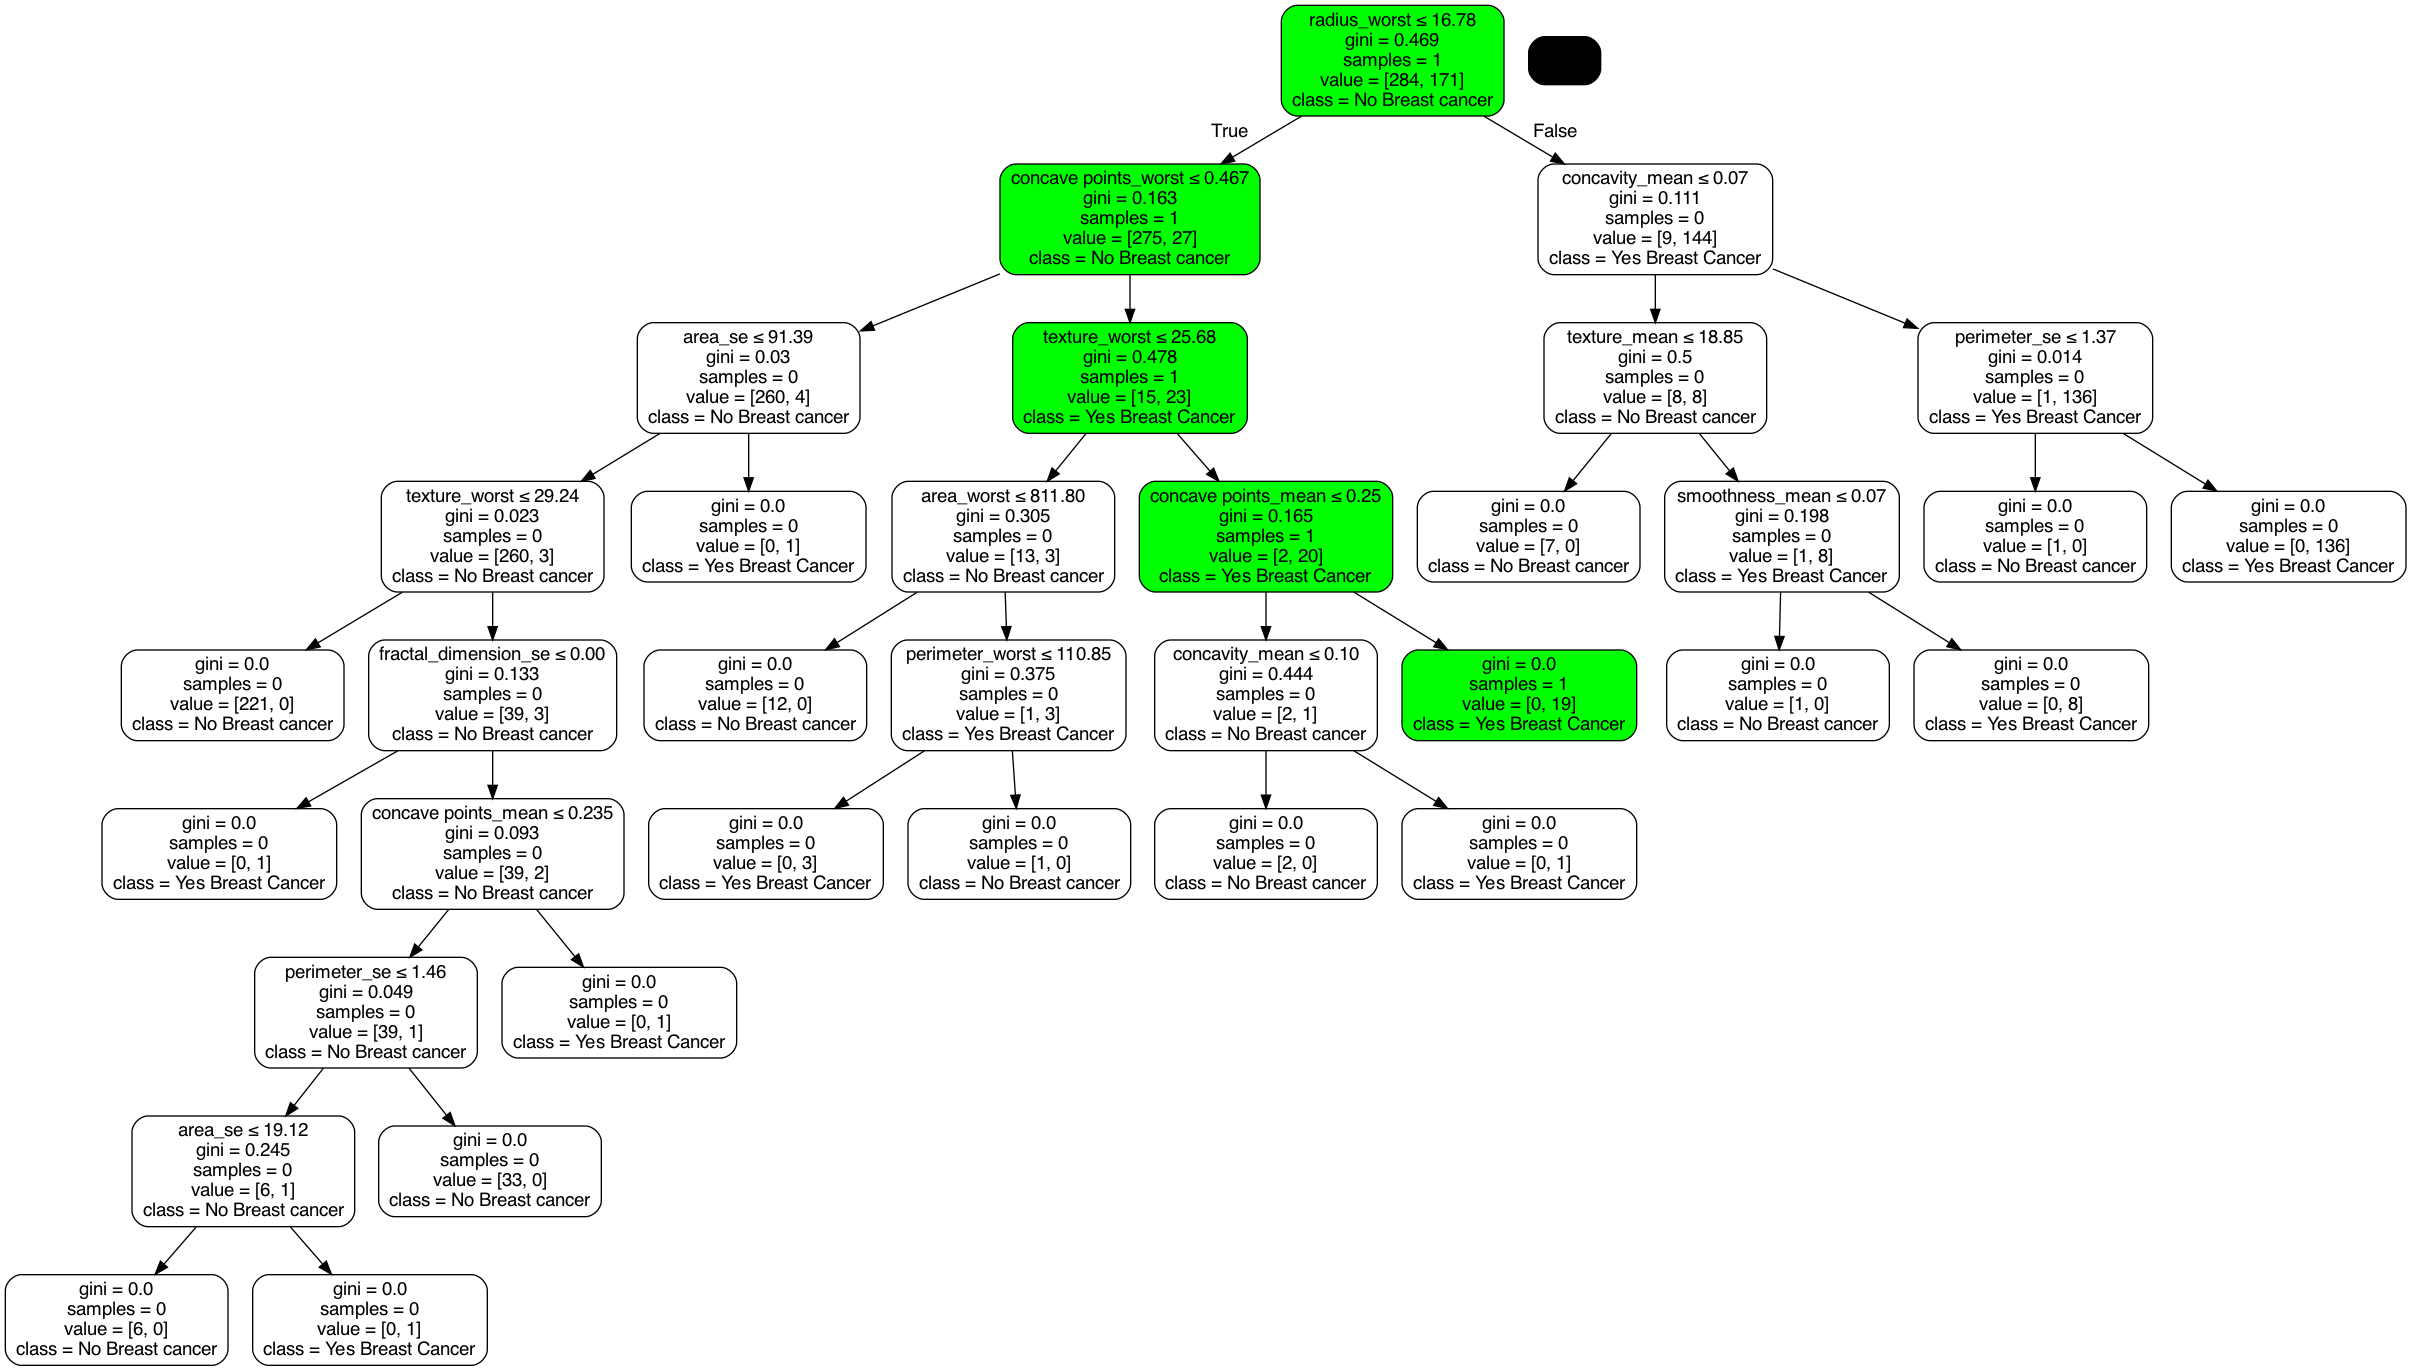

In [42]:
INDX = 71
exp_type = "true_positives"
#instance = new_min_l2_instance_instance_arr

img = visualize_decision_tree_path( clf,  export_decision_tree(clf, class_names, dataset_name, filepath), dice_input, INDX, 'true_positives', filepath)
img



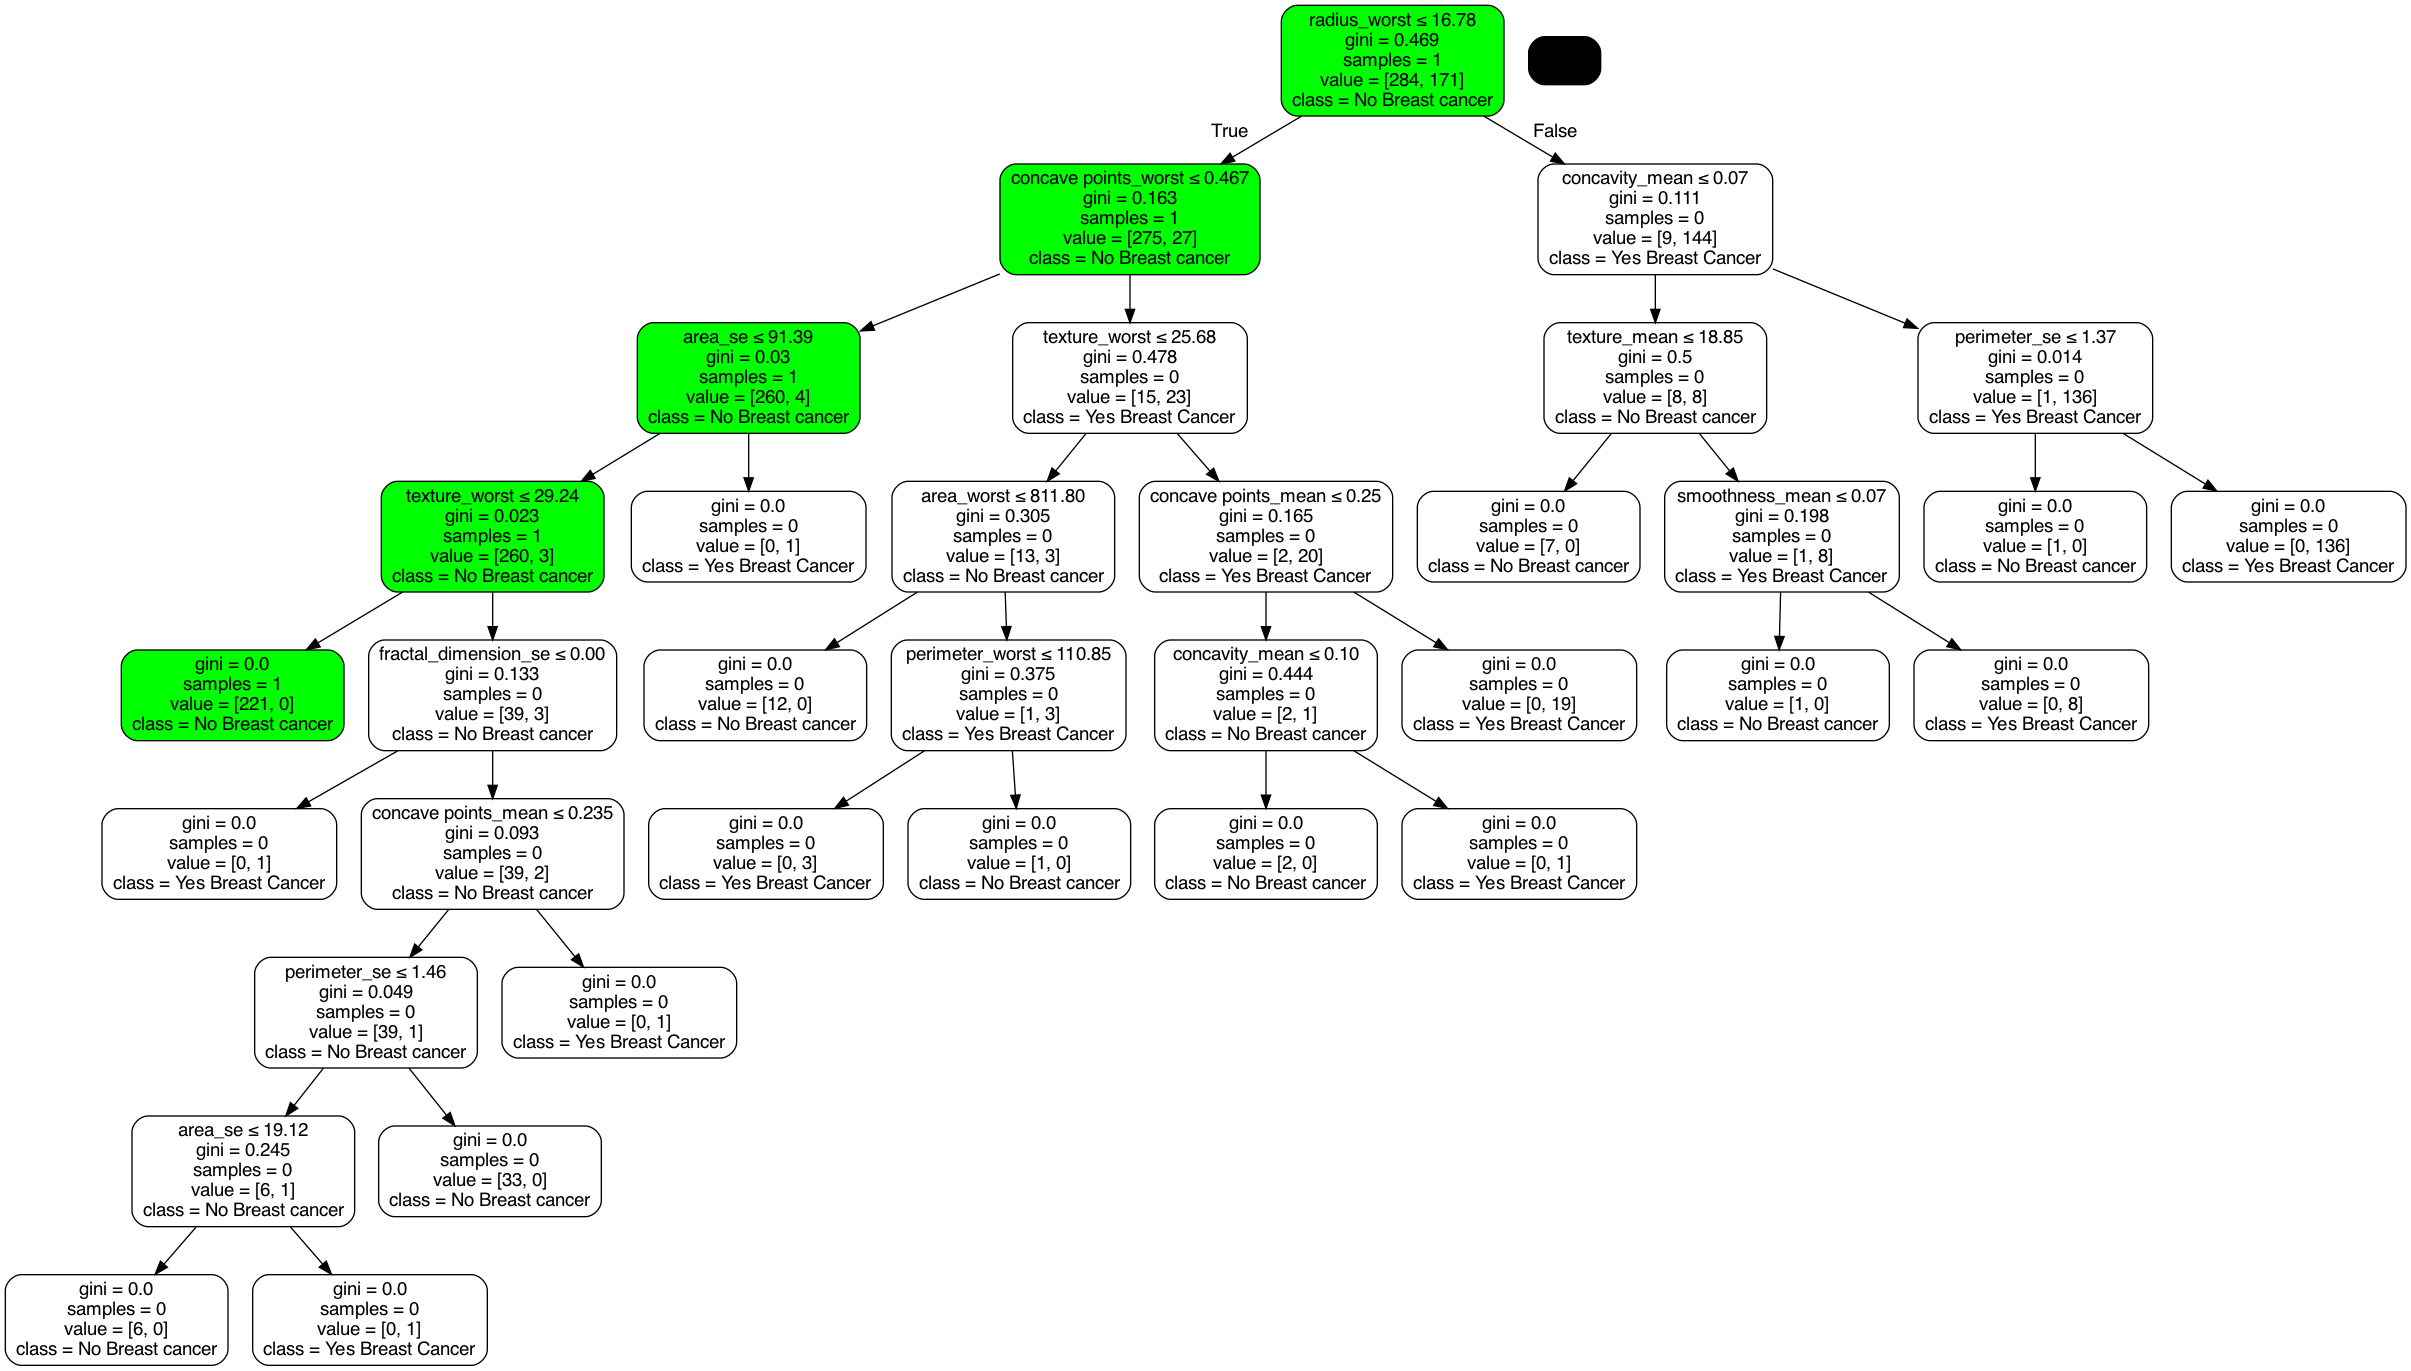

In [44]:
#exp_type = "L2_max"
INDX = 71
#instance = instance
#exp_type = "true_positives"
#instance = new_min_l2_instance_instance_arr

img = visualize_decision_tree_path( clf,  export_decision_tree(clf, class_names, dataset_name, filepath), dice_cf, INDX, 'true_positives', filepath)
img


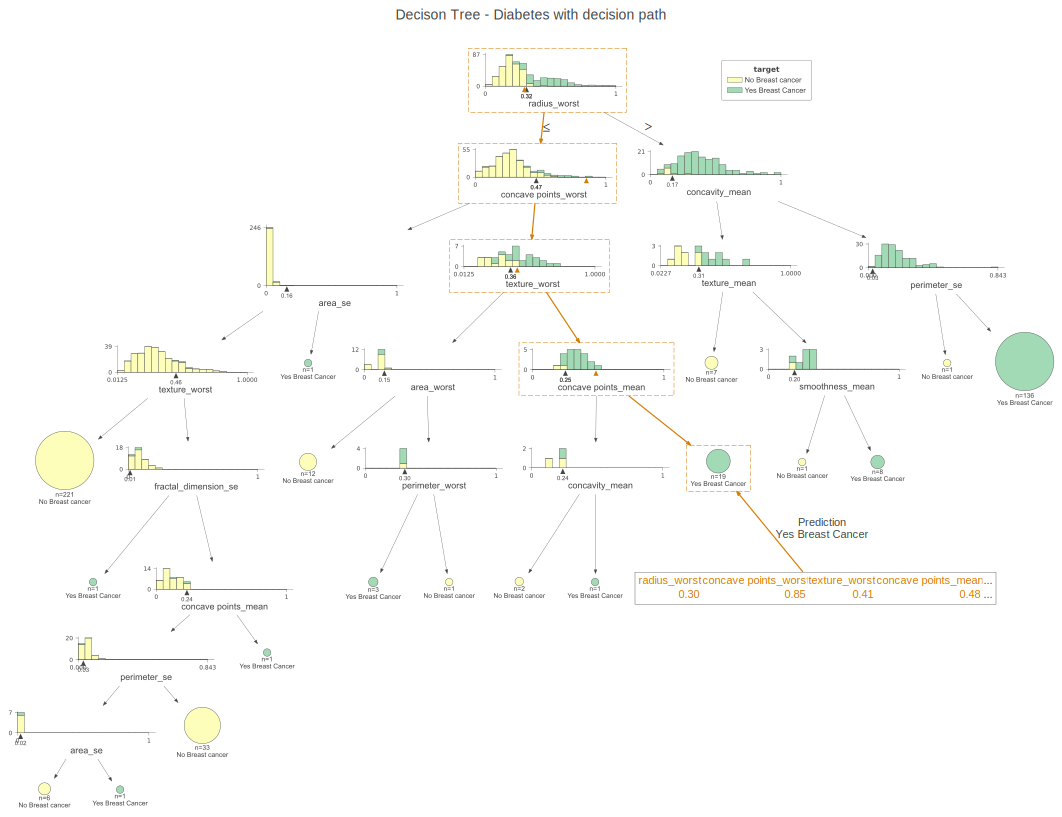

In [49]:
viz = dtreeviz(clf, 
               x_data=X_train,
               y_data=y_train,
               target_name='target',
               feature_names=df_info.feature_names, 
               class_names=class_names,
               title="Decison Tree - Diabetes with decision path",
               #orientation="LR", 
               #X=arr,
               X=dice_input
               #X=X_test[0]
               )
viz.view()
viz

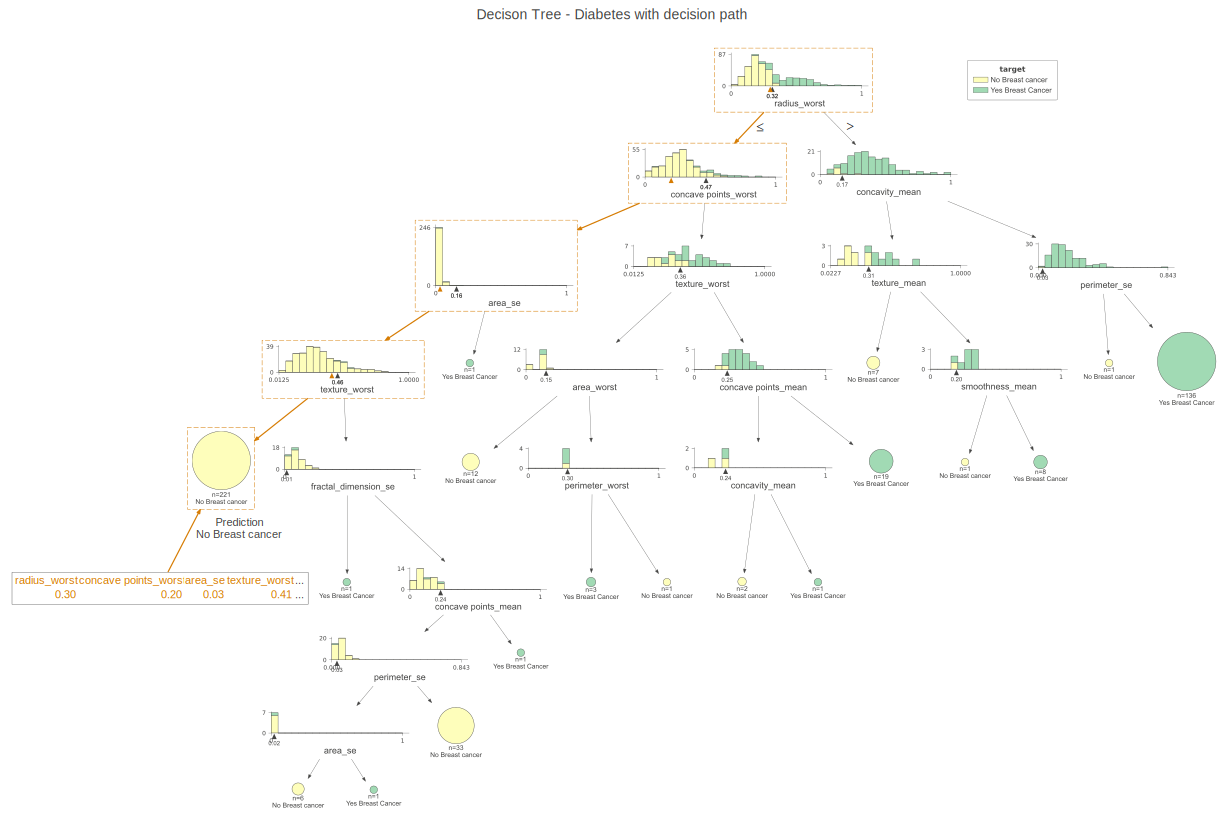

In [50]:
viz = dtreeviz(clf, 
               x_data=X_train,
               y_data=y_train,
               target_name='target',
               feature_names=df_info.feature_names, 
               class_names=class_names,
               title="Decison Tree - Diabetes with decision path",
               #orientation="LR", 
               #X=arr,
               X=dice_cf
               #X=X_test[0]
               )
viz.view()
viz